## Titanic : machine learning from disaster solution

### Part_1: data analysis and feature engineering

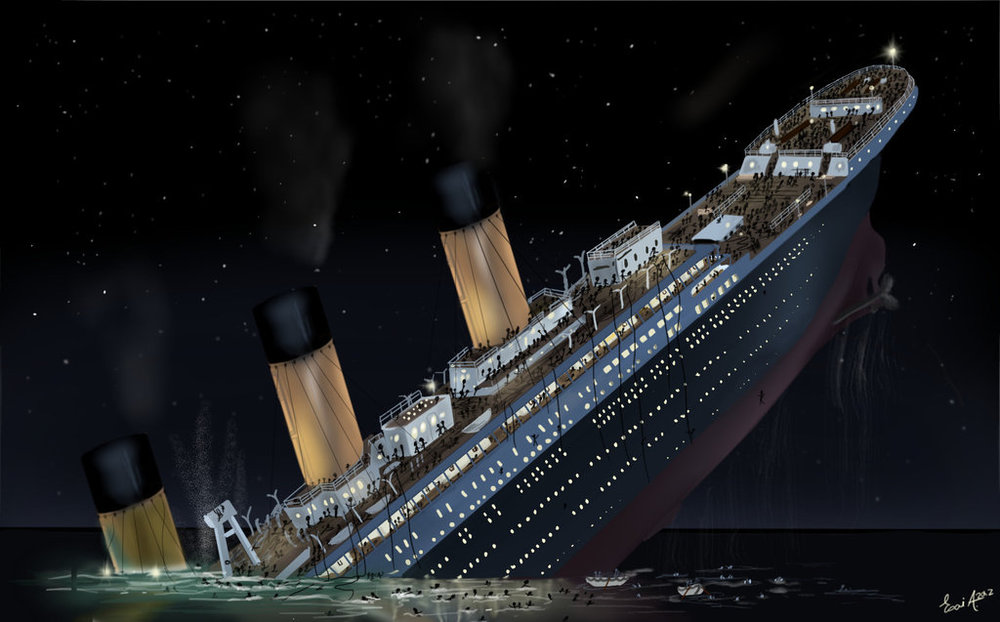

In [1]:
from IPython.display import Image
import  matplotlib.pyplot  as plt
import seaborn as sns
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
sns.set()
%matplotlib inline

Image("image/titanic.jpg")

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# 0 for not survived and 1 for survived
# Pclass: class for position
#sibsp: # of siblings / spouses aboard the Titanic
#parch: # of parents / children aboard the Titanic
#embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [4]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
# Age and Cabin data are partially missing
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# Age and Cabin data are partially missing
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
# plot by chart of dead and survived
def bar_show(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

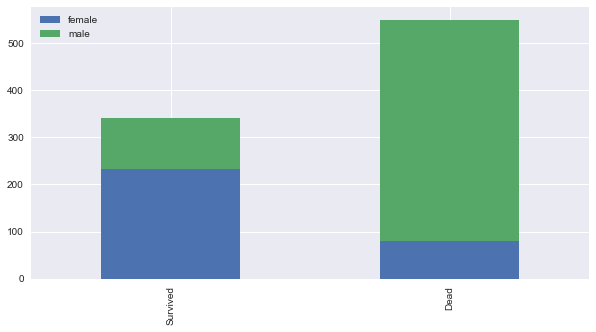

In [10]:
bar_show('Sex')

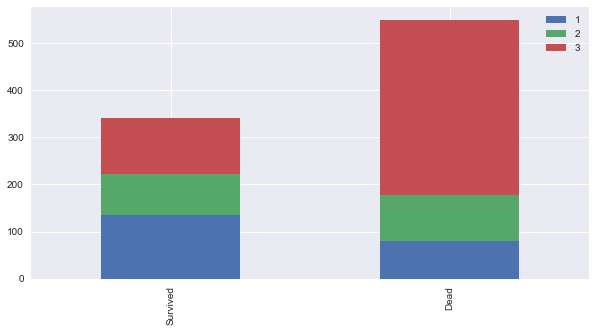

In [11]:
bar_show ('Pclass')

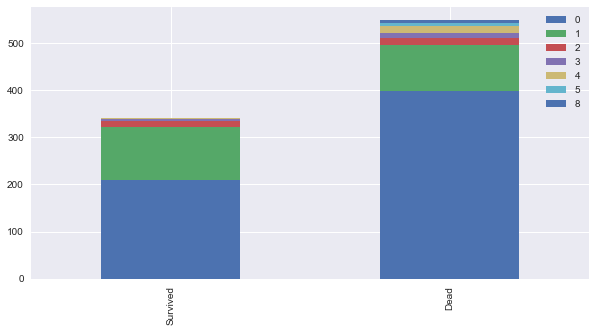

In [12]:
bar_show('SibSp')

##### It can be shown from reason.jpg below that the pclass is the main reason why titanic sank. So the pclass feature will be the focus.

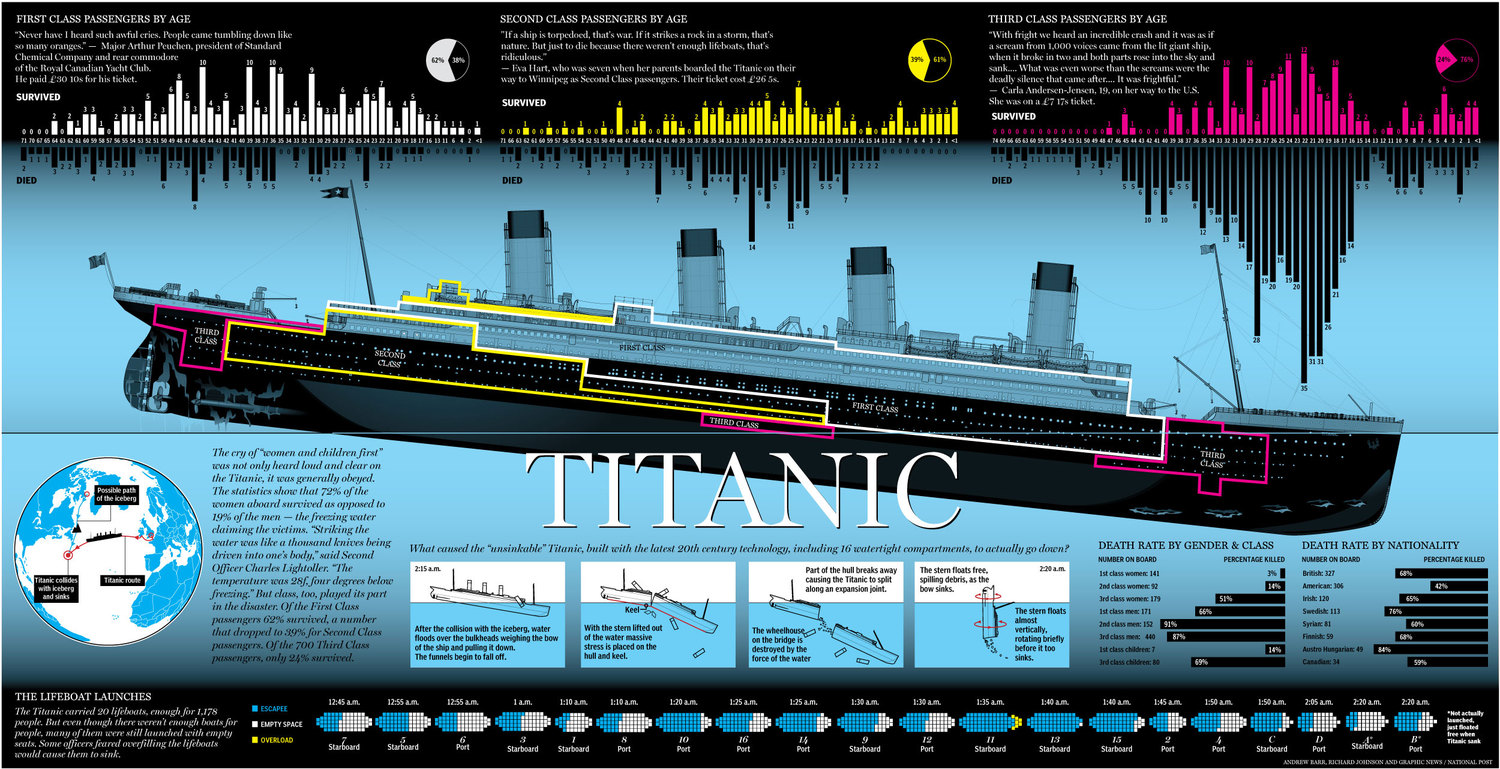

In [13]:
Image("image/structure.jpg")

In [14]:
# combine dataset
total_dataset = [train, test] 

##### * Name

In [15]:
for dataset in total_dataset:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [16]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Title, dtype: int64

In [17]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

In [18]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
for dataset in total_dataset:
    dataset['Title'] = dataset['Title'].map(title_mapping)

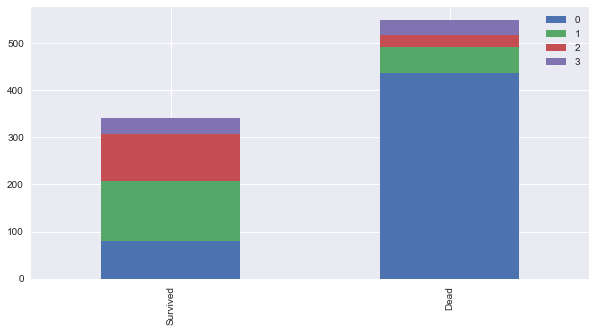

In [19]:
bar_show('Title')

In [20]:
# now the name attribute is no more important
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [21]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0


#### * Sex

In [22]:
sex_mapping = {"male": 0, "female": 1}
for dataset in total_dataset:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

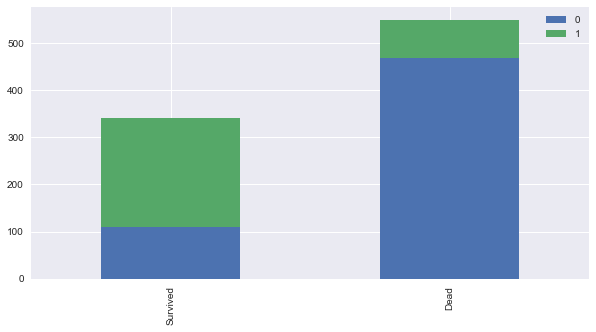

In [23]:
bar_show('Sex')

#### * Age

In [24]:
# fill missing age with average age for each title (Mr, Mrs, Miss, Others)
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

In [25]:
train.head(10)
train.groupby("Title")["Age"].transform("median")

0      30.0
1      35.0
2      21.0
3      35.0
4      30.0
5      30.0
6      30.0
7       9.0
8      35.0
9      35.0
10     21.0
11     21.0
12     30.0
13     30.0
14     21.0
15     35.0
16      9.0
17     30.0
18     35.0
19     35.0
20     30.0
21     30.0
22     21.0
23     30.0
24     21.0
25     35.0
26     30.0
27     30.0
28     21.0
29     30.0
       ... 
861    30.0
862    35.0
863    21.0
864    30.0
865    35.0
866    21.0
867    30.0
868    30.0
869     9.0
870    30.0
871    35.0
872    30.0
873    30.0
874    35.0
875    21.0
876    30.0
877    30.0
878    30.0
879    35.0
880    35.0
881    30.0
882    21.0
883    30.0
884    30.0
885    35.0
886     9.0
887    21.0
888    21.0
889    30.0
890    30.0
Name: Age, Length: 891, dtype: float64

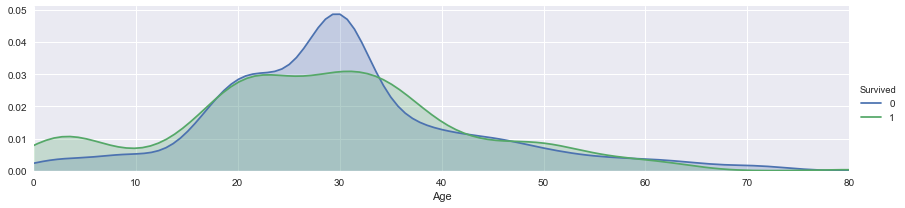

In [26]:
# plt relation with age and suvival
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
 
plt.show()

#### * Binning

In [27]:
#Binning/Converting Numerical Age to Categorical Variable

for dataset in total_dataset:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4

In [28]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,S,0


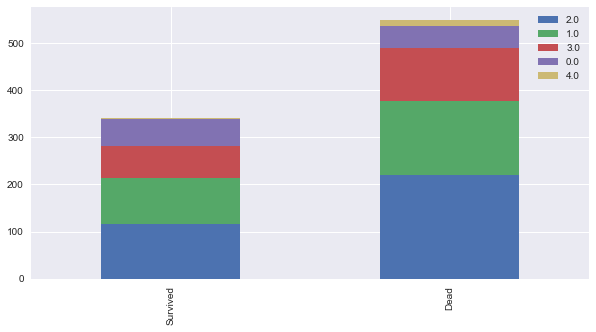

In [29]:
bar_show('Age')

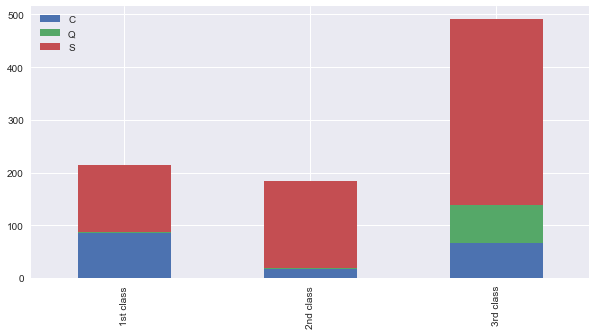

In [30]:
# fill the missing data
Pclass1 = train[train['Pclass']==1]['Embarked'].value_counts()
Pclass2 = train[train['Pclass']==2]['Embarked'].value_counts()
Pclass3 = train[train['Pclass']==3]['Embarked'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

In [31]:
for dataset in total_dataset:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [32]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in total_dataset:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [33]:
# fill missing Fare with median fare for each Pclass
train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)
test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace=True)
train.head(50)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,0,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,0,0
5,6,0,3,0,2.0,0,0,330877,8.4583,NaN,2,0
6,7,0,1,0,3.0,0,0,17463,51.8625,E46,0,0
7,8,0,3,0,0.0,3,1,349909,21.0750,NaN,0,3
8,9,1,3,1,2.0,0,2,347742,11.1333,NaN,0,2
9,10,1,2,1,0.0,1,0,237736,30.0708,NaN,1,2


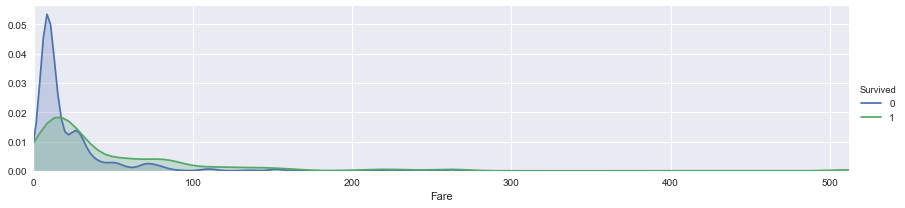

In [34]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()
 
plt.show()

In [35]:
for dataset in total_dataset:
    dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

In [36]:
train.Cabin.value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
D                  3
C22 C26            3
E101               3
F2                 3
F33                3
B57 B59 B63 B66    2
C68                2
B58 B60            2
E121               2
D20                2
E8                 2
E44                2
B77                2
C65                2
D26                2
E24                2
E25                2
B20                2
C93                2
D33                2
E67                2
D35                2
D36                2
C52                2
F4                 2
C125               2
C124               2
                  ..
F G63              1
A6                 1
D45                1
D6                 1
D56                1
C101               1
C54                1
D28                1
D37                1
B102               1
D30                1
E17                1
E58                1
F E69              1
D10 D12            1
E50                1
A14          

In [37]:
for dataset in total_dataset:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

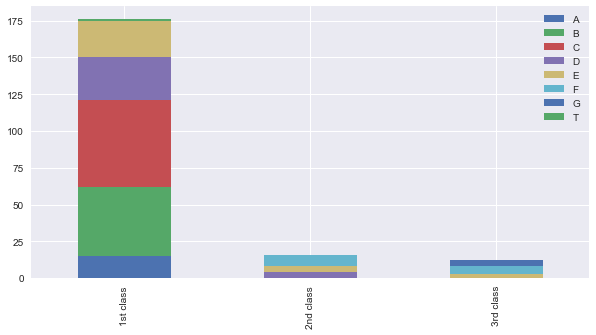

In [38]:
Pclass1 = train[train['Pclass']==1]['Cabin'].value_counts()
Pclass2 = train[train['Pclass']==2]['Cabin'].value_counts()
Pclass3 = train[train['Pclass']==3]['Cabin'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

In [39]:
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in total_dataset:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

In [40]:
# fill missing Fare with median fare for each Pclass
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

#### * Family Size

In [41]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

(0, 11.0)

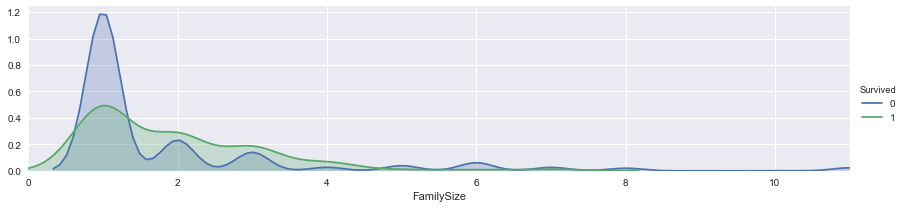

In [42]:

facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'FamilySize',shade= True)
facet.set(xlim=(0, train['FamilySize'].max()))
facet.add_legend()
plt.xlim(0)

In [43]:
family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
for dataset in total_dataset:
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)

In [44]:
features_drop  = ['Ticket', 'SibSp', 'Parch']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)

In [45]:
train_data = train.drop('Survived', axis=1)
target = train['Survived']

train_data.shape, target.shape

((891, 8), (891L,))

### Part_2: modeling

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null float64
Fare          891 non-null float64
Cabin         891 non-null float64
Embarked      891 non-null int64
Title         891 non-null int64
FamilySize    891 non-null float64
dtypes: float64(4), int64(5)
memory usage: 62.7 KB


In [48]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[ 0.82222222  0.76404494  0.80898876  0.83146067  0.87640449  0.82022472
  0.85393258  0.79775281  0.84269663  0.84269663]


In [49]:
# kNN Score
round(np.mean(score)*100, 2)

82.6

In [50]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[ 0.76666667  0.80898876  0.76404494  0.7752809   0.87640449  0.76404494
  0.83146067  0.82022472  0.74157303  0.78651685]


In [51]:
# decision tree Score
round(np.mean(score)*100, 2)

79.35

In [52]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[ 0.77777778  0.80898876  0.83146067  0.79775281  0.86516854  0.79775281
  0.83146067  0.80898876  0.78651685  0.80898876]


In [53]:
# Random Forest Score
round(np.mean(score)*100, 2)

81.15

In [56]:
clf  ==  GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[ 0.78888889  0.84269663  0.80898876  0.76404494  0.85393258  0.80898876
  0.83146067  0.82022472  0.75280899  0.79775281]


In [57]:
# Naive Bayes Score
round(np.mean(score)*100, 2)

80.7

In [58]:
clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[ 0.83333333  0.80898876  0.83146067  0.82022472  0.84269663  0.82022472
  0.84269663  0.85393258  0.83146067  0.86516854]


In [59]:
round(np.mean(score)*100,2)

83.5

In [60]:
clf = SVC()
clf.fit(train_data, target)

test_data = test.drop("PassengerId", axis=1).copy()
prediction = clf.predict(test_data)

In [61]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": prediction
    })

submission.to_csv('submission.csv', index=False)

In [62]:
submission = pd.read_csv('submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
